# 8. Make Predictions

In [1]:
import pandas as pd
import pickle
import json
import os
from collections import defaultdict as dd

In [2]:
with open(f'../models/final_models/model.pickle', 'rb') as f:
    model = pickle.load(f)

/Applications/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [10]:
manip_type = 'Head2Head'

csv_list = os.listdir(f'../data/curated/{manip_type}')
csv_list.sort()

In [5]:
tuning_df = pd.read_csv('../models/tuning/' +'guanganb_BrownlowH2H_RFR.csv')
col = eval(tuning_df.loc[tuning_df['Val Brownlow Metric'].argmax()]['features'])

In [53]:
def predict_brownlow(csv_list):
    json_dict = dict()

    tally = dd(int)

    data = pd.DataFrame()
    for file in csv_list:
        if file[-8:] != '.parquet':
            continue

        game_dict = dict()
        if '2022' in file:
            
            round = file.split()[2]
            team1 = file.split()[3]
            team2 = file.split()[5]
            game = team1 + ' v ' + team2

            data = pd.read_parquet(f'../data/curated/{manip_type}/{file}')

            player1 = data['player1']
            player2 = data['player2']
            pred = model.predict(data[col])
            pred = pd.DataFrame({'player1': player1, 'player2': player2, 'pred': pred})

            # initialise tallies
            pred_leaderboard = dd(int)
            

            for row in pred.iterrows(): # then get predicted votes
                if row[1]['pred'] > 0:
                    pred_leaderboard[row[1]['player1']] += 1
                    pred_leaderboard[row[1]['player2']] -= 1

                elif row[1]['pred'] < 0:
                    pred_leaderboard[row[1]['player1']] -= 1
                    pred_leaderboard[row[1]['player2']] += 1
            
            # turn leaderboard into a useable list
            pred_leaderboard = list(pred_leaderboard.items())
            pred_leaderboard.sort(key = lambda x:x[1],  reverse= True)

            three_votes = pred_leaderboard[0][0]
            
            two_votes = pred_leaderboard[1][0]

            one_vote = pred_leaderboard[2][0]
            
            game_dict[3] = three_votes
            game_dict[2] = two_votes
            game_dict[1] = one_vote

            if f'Round {round}' in json_dict:
                json_dict[f'Round {round}'][game] = game_dict
            else:
                json_dict[f'Round {round}'] = dict()
                json_dict[f'Round {round}'][game] = game_dict

            tally[three_votes] += 3
            tally[two_votes] += 2
            tally[one_vote] += 1
    
    return json_dict, tally

In [54]:
json_dict, tally = predict_brownlow(csv_list) 

In [55]:
with open('../presentables/game_by_game_prediction.json', 'w') as f:
    json.dump(json_dict, f, indent=2)

In [56]:
tally_list = list(tally.items())
tally_list.sort(key = lambda x:x[1], reverse=True)

In [57]:
tally_df = pd.DataFrame(tally_list, columns = ['Player', 'Votes'], index = [i+1 for i in range(len(tally_list))])
tally_df['Ranking'] = tally_df.index
tally_df = tally_df[['Ranking', 'Player', 'Votes']]
tally_df.head(30)

,Ranking,Player,Votes
1,1,Touk Miller,33
2,2,Clayton Oliver,32
3,3,Patrick Cripps,29
4,4,Lachie Neale,28
5,5,Christian Petracca,24
6,6,Andrew Brayshaw,20
7,7,Sam Walsh,20
8,8,Connor Rozee,19
9,9,Dion Prestia,17
10,10,Chad Warner,17


In [58]:
tally_df.to_csv('../presentables/leaderboard.csv', index = False)

# Model Analysis

In [59]:
feature_importance = pd.DataFrame({'Features': model.feature_names_in_, 'Importance': model.feature_importances_})
feature_importance = feature_importance.sort_values('Importance', ascending=False)
feature_importance

,Features,Importance
0,AFLCA_votes,0.477994
1,Disposals,0.038245
3,Goals,0.021901
2,Contested Possessions,0.021400
4,Centre Clearances,0.021015
5,Intercepts,0.018525
6,Clearances,0.018354
9,Handballs,0.018118
23,Metres Gained,0.017516
8,Hitouts,0.017348


/var/folders/xg/8w_3dndd6l5c3n99vd7vd3f40000gn/T/ipykernel_21660/3261477763.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(feature_importance['Features'], rotation = 90);


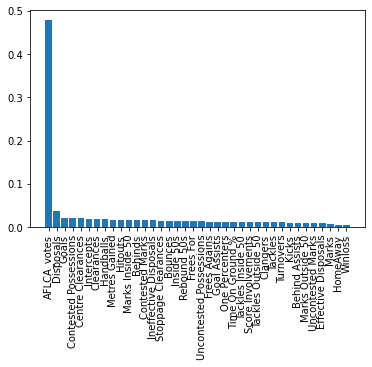

In [61]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots();
ax.bar(height= feature_importance['Importance'],  x = feature_importance['Features']);
ax.set_xticklabels(feature_importance['Features'], rotation = 90);